In [1]:
import numpy as np
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import pandas as pd
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
from scipy.stats import norm
sns.reset_defaults()
sns.set(style='darkgrid', palette='colorblind')


In [2]:
from clustering_utils import umap,tSNE,compute_most_represented_class_per_cluster,substitute_classes_labels
from cVAE_architecture2 import cVAE2, loss_vae
from cVAE_train_utils2 import train_cVAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 128
cmap = plt.cm.get_cmap('viridis', 10)


In [3]:

def plot_components(z_test, n_clusters, clustering, max_plots=None):
    if max_plots is None:
        max_plots = z_test.shape[1]
    
    n_components = n_clusters
    n_dimensions = z_test.shape[1]
    # Calculate the number of rows needed for the grid
    num_rows = (max_plots + 2) // 3  
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))

    colors = plt.cm.jet(np.linspace(0, 1, n_components))

    for dim in range(max_plots):
        row = dim // 3  
        col = dim % 3   
        x = np.linspace(z_test[:, dim].min(), z_test[:, dim].max(), 100)

        for i in range(n_components):
            # Extract mean and covariance matrix for the current Gaussian component
            mean = clustering.means_[i]
            cov_matrix = clustering.covariances_[i]

            # Calculate the PDF values using the 1D Gaussian distribution
            y = norm.pdf(x, loc=mean[dim], scale=np.sqrt(cov_matrix[dim, dim]))
            axes[row, col].plot(x, y, label=f'Cluster {i}', color=colors[i])
            axes[row, col].fill_between(x, 0, y, alpha=0.05, color=colors[i])

        axes[row, col].set_xlabel(f"Dimension {dim + 1}")
        axes[row, col].set_ylabel("Probability Density")
        axes[row, col].set_title(f'Distributions in Dimension {dim + 1}')

    # Collect legend information from one of the subplots
    legend_labels = [line.get_label() for line in axes[0, 0].lines]
    legend_handles = [line for line in axes[0, 0].lines]

    # Hide any empty subplots if max_plots is not a multiple of 3
    for dim in range(max_plots, num_rows * 3):
        row = dim // 3
        col = dim % 3
        fig.delaxes(axes[row, col])

    # Create a single legend for all subplots and place it under the last row of subplots
    legend = fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=n_components,)
    
    plt.tight_layout()
    plt.show()


In [4]:
def tSNE(z, latent_space, clustering_labels, true_labels=None, cmap='viridis', aff_true_labels=True, data=None):
    # t-SNE projection
    tSNE_2d = TSNE(n_components=2) 
    proj_2d = tSNE_2d.fit_transform(z)
    
    # Create a figure with two subplots in one row
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the first scatter plot on the first subplot (ax1)
    scatter1 = ax1.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], s=20, c=clustering_labels, alpha=0.9, cmap=cmap)
    legend1 = ax1.legend(*scatter1.legend_elements(), loc="upper left", title="Classes", fontsize=5)
    
    ax1.set_title(f'Prediction (Number of clusters ={latent_space})', fontsize=12)
    ax1.set_xlabel('tSNE_1', fontsize=12)
    ax1.set_ylabel('tSNE_2', fontsize=12)
    
    # Plot the second scatter plot on the second subplot (ax2)
    if aff_true_labels:
        scatter2 = ax2.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], s=20, c=true_labels, alpha=0.9, cmap="winter")
        legend2 = ax2.legend(*scatter2.legend_elements(), loc="upper left", title="Classes", fontsize=5)
        ax2.set_title(f'Mutations', fontsize=12)
        ax2.set_xlabel('tSNE_1', fontsize=12)
        ax2.set_ylabel('tSNE_2', fontsize=12)

    # Save the figure with both subplots
    plt.savefig('./Results/tSNE_comparison_Zdim'+str(latent_space)+str(data)+'.png')
    
    # Display the figure
    plt.show()
    
    return proj_2d
        
        

In [5]:
def pourcentage_label(label,l,y):
    count_0 = 0
    count_1 = 0
    for i in range (len(y)):
        if l[i]==label and y[i]==0:
            count_0+=1
        if l[i]==label and y[i]==1:
            count_1+=1
    
    if count_0 > count_1: 
        return(0)
    else : 
        return(1)    

def pourcentage_cells(labels,y):
    print("")
    print("number of control cells  = ",np.sum(y==0))
    print("number of Mutation cells  = ",np.sum(y==1))
    control =[]
    mutation = []
    for label in set(labels):
        category = pourcentage_label(label,labels,y)
        if category:
            mutation.append(label)
        else: 
            control.append(label)
            
    print (f'Mutatation labels are {mutation}' )
    print (f'control labels are {control}' )

## Wild vs PIK3CA

In [6]:
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((192, 192)),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(root='../cropped_cells_original_rotated_balanced', transform=transform)

train_proportion = 0.8
test_proportion = 1 - train_proportion

# Calculate the number of samples for each split
total_samples = len(dataset)
train_samples = int(train_proportion * total_samples)
test_samples = total_samples - train_samples

# Use random_split to create train and test datasets with the calculated proportions
train_dataset, test_dataset = random_split(dataset, [train_samples, test_samples])

# Create DataLoader instances to load batches during training and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: torch.Size([4026, 1, 192, 192])
Y_train shape: torch.Size([4026])
X_test shape: torch.Size([1007, 1, 192, 192])
Y_test shape: torch.Size([1007])


### cVAE with alpha = 16

In [14]:
autoencoder_cvae=cVAE2(num_labels=2, latent_dim=128,input_size=192,alpha=16)
autoencoder_cvae.load_state_dict(torch.load('./models/cVAE_1_16_zdim_128_beta_1.0_epochs_20.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

**Clustering using GaussianMixture : 5 clusters**

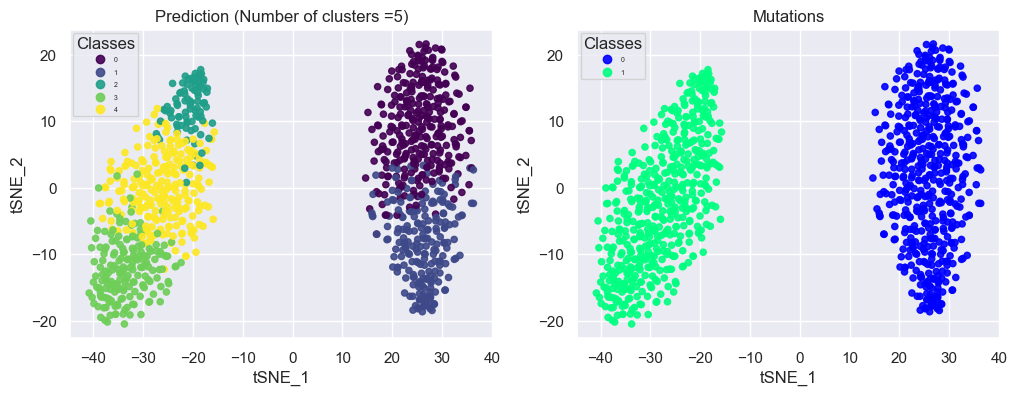


number of control cells  =  503
number of Mutation cells  =  504
Mutatation labels are [2, 3, 4]
control labels are [0, 1]


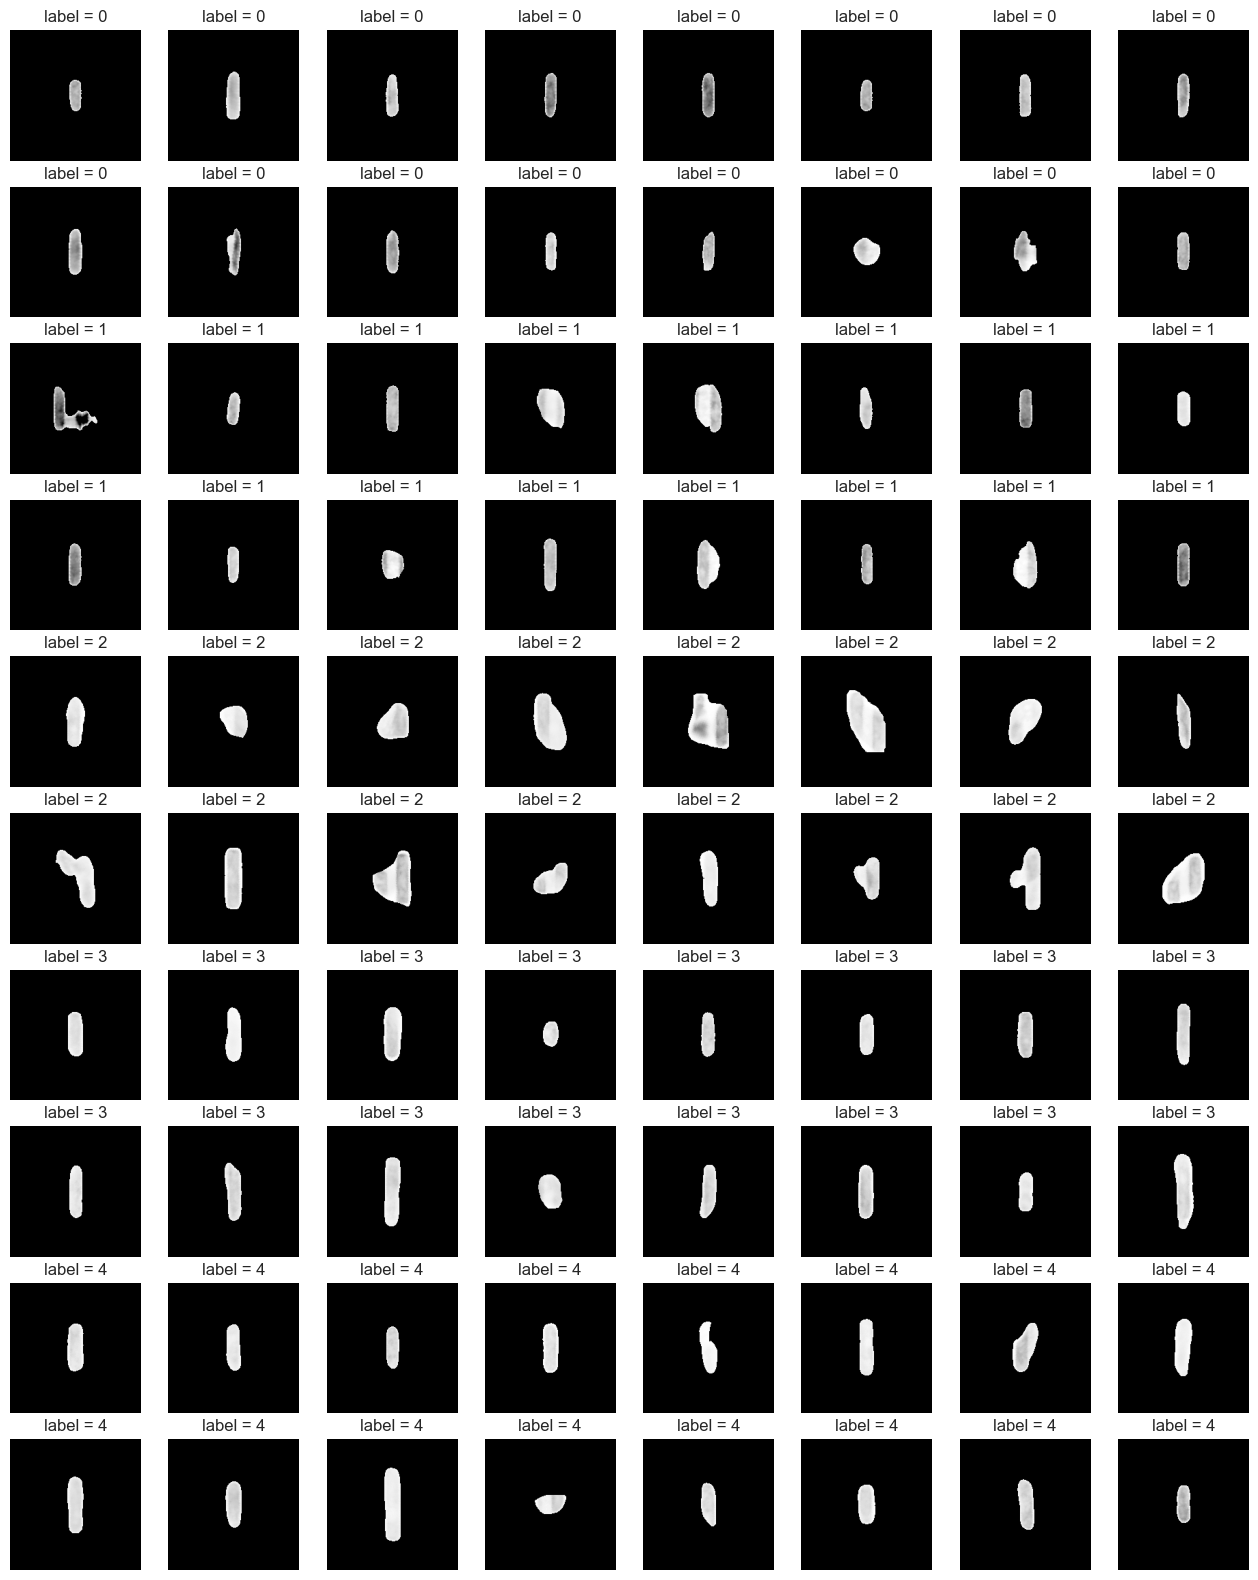

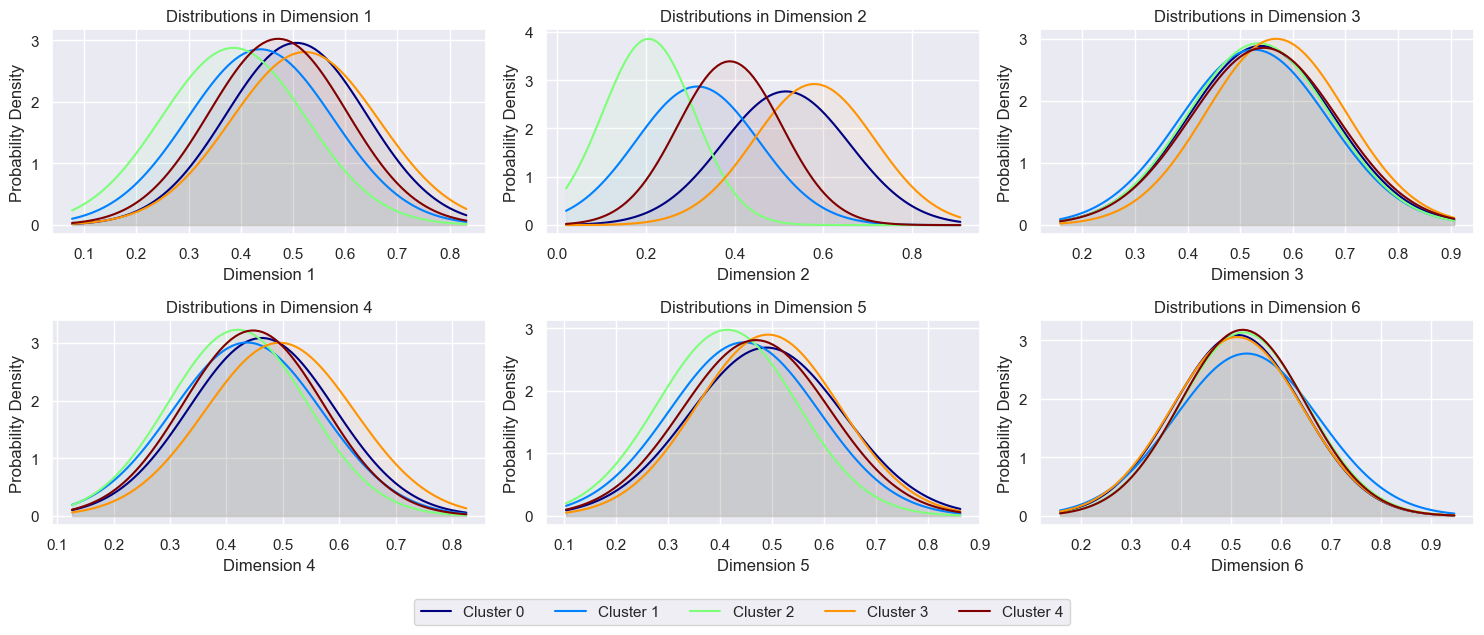

Silhouette: 0.3943, DB: 0.8204, CH: 4109.0013


In [15]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 5
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
proj_2d = tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=5,data="cells",cmap=cmap)
pourcentage_cells(clustering_labels,y_test)

# Samples from each cluster
nb_samples = 16
unique_labels = list(set(clustering_labels))
n_clusters = len(unique_labels)
fig, axes = plt.subplots(n_clusters * 2, nb_samples // 2, figsize=( nb_samples ,n_clusters * 4))

for label_index, label in enumerate(unique_labels):
    cluster_samples = X_test[clustering_labels == label]
    for row in range(2):
        for col in range(nb_samples // 2):
            sample_index = row * (nb_samples // 2) + col
            if sample_index < len(cluster_samples):
                axes[label_index * 2 + row, col].imshow(cluster_samples[sample_index][0], cmap='gray')
                axes[label_index * 2 + row, col].set_title(f"label = {label}")
                axes[label_index * 2 + row, col].grid(False)
                axes[label_index * 2 + row, col].axis('off')

plt.show()
plot_components(z_test,n_clusters,clustering,max_plots=6)

s_16_5 = silhouette_score(proj_2d, clustering_labels)
db_16_5 = davies_bouldin_score(proj_2d, clustering_labels)
ch_16_5 = calinski_harabasz_score(proj_2d, clustering_labels)
print(f"Silhouette: {s_16_5:.4f}, DB: {db_16_5:.4f}, CH: {ch_16_5:.4f}")


**Clustering using GaussianMixture : 7 clusters**

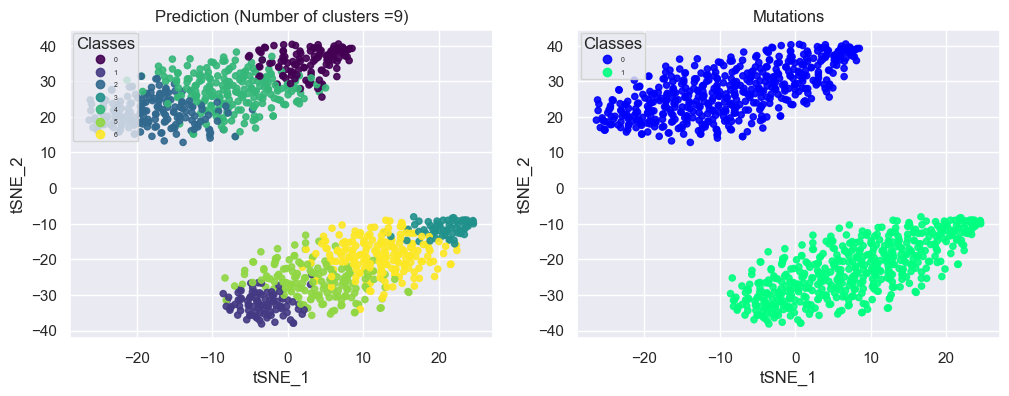


number of control cells  =  503
number of Mutation cells  =  504
Mutatation labels are [1, 3, 5, 6]
control labels are [0, 2, 4]


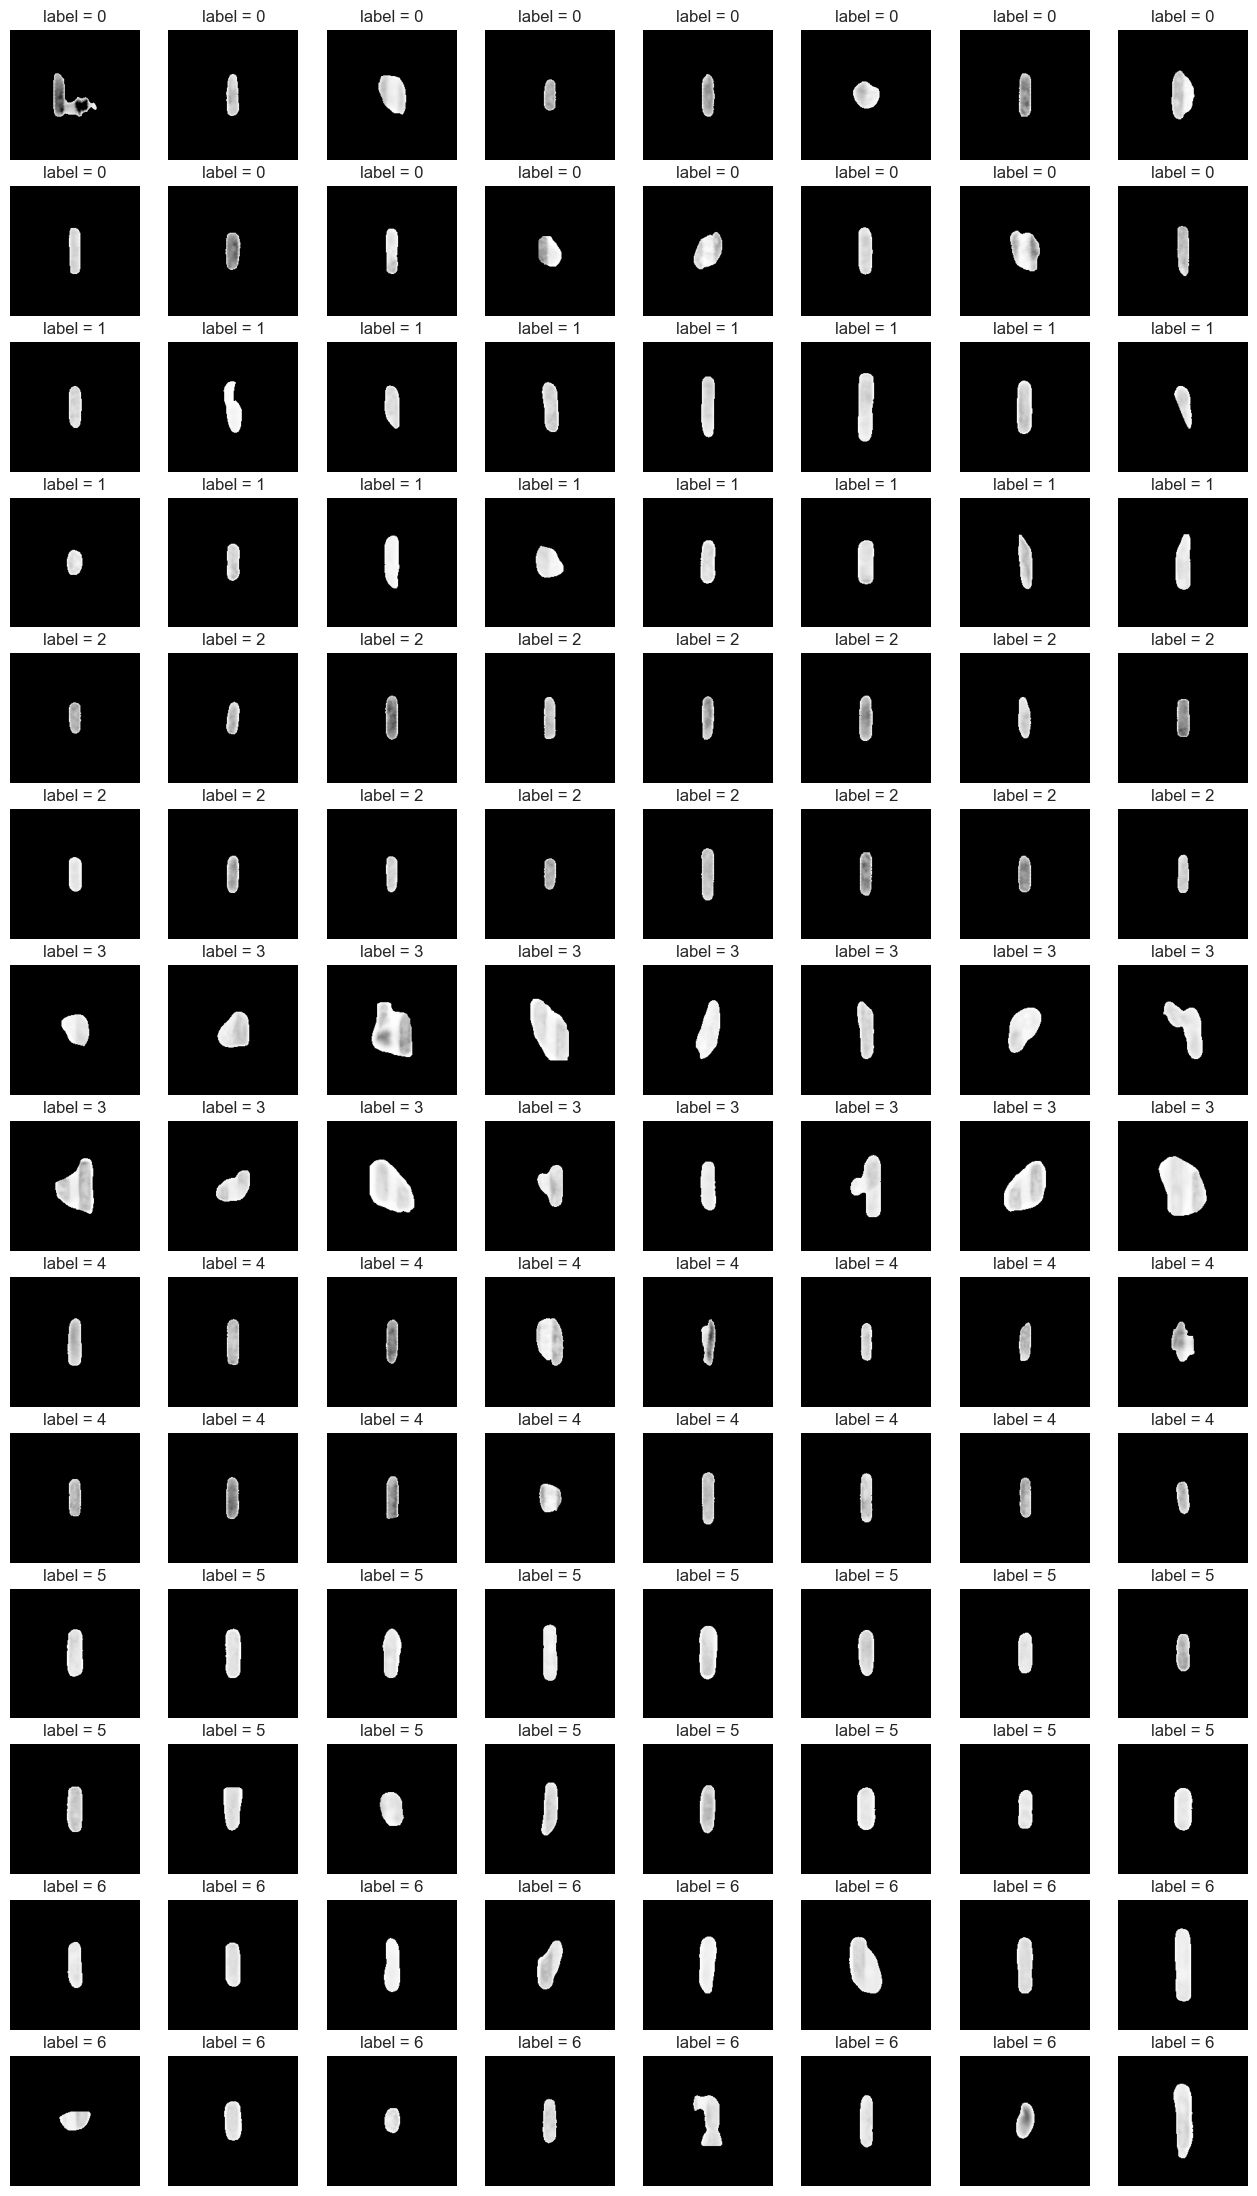

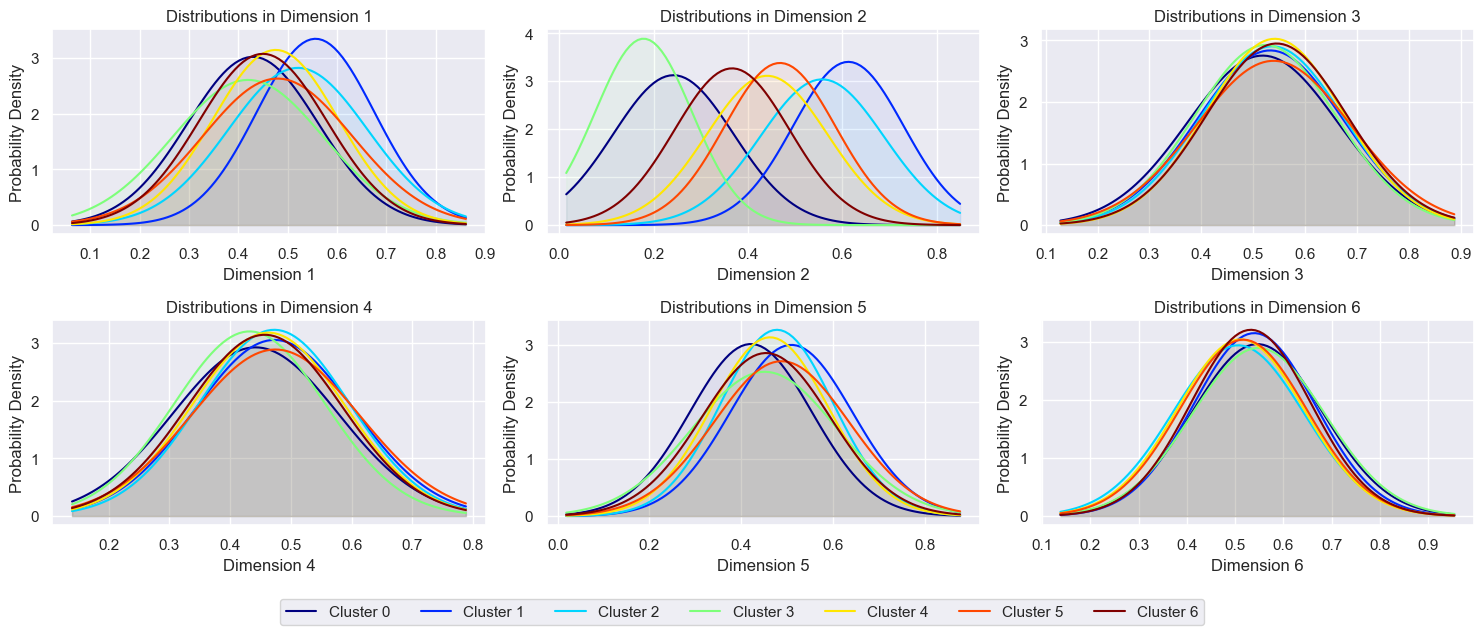

Silhouette: 0.3011, DB: 0.9610, CH: 3552.7058


In [16]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 7
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
proj_2d = tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=9,data="cells")
pourcentage_cells(clustering_labels,y_test)

# Samples from each cluster
nb_samples = 16
unique_labels = list(set(clustering_labels))
n_clusters = len(unique_labels)
fig, axes = plt.subplots(n_clusters * 2, nb_samples // 2, figsize=( nb_samples ,n_clusters * 4))

for label_index, label in enumerate(unique_labels):
    cluster_samples = X_test[clustering_labels == label]
    for row in range(2):
        for col in range(nb_samples // 2):
            sample_index = row * (nb_samples // 2) + col
            if sample_index < len(cluster_samples):
                axes[label_index * 2 + row, col].imshow(cluster_samples[sample_index][0], cmap='gray')
                axes[label_index * 2 + row, col].set_title(f"label = {label}")
                axes[label_index * 2 + row, col].grid(False)
                axes[label_index * 2 + row, col].axis('off')

plt.show()

plot_components(z_test,n_clusters,clustering,max_plots=6)

s_16_9 = silhouette_score(proj_2d, clustering_labels)
db_16_9 = davies_bouldin_score(proj_2d, clustering_labels)
ch_16_9 = calinski_harabasz_score(proj_2d, clustering_labels)
print(f"Silhouette: {s_16_9:.4f}, DB: {db_16_9:.4f}, CH: {ch_16_9:.4f}")


### cVAE with alpha = 8

In [17]:
autoencoder_cvae=cVAE2(num_labels=2, latent_dim=128,input_size=192, alpha=8)
autoencoder_cvae.load_state_dict(torch.load('./models/cVAE_1_8_zdim_128_beta_1.0_epochs_20.pth',map_location=torch.device('cpu')))


<All keys matched successfully>

**Clustering using GaussianMixture : 5 clusters**

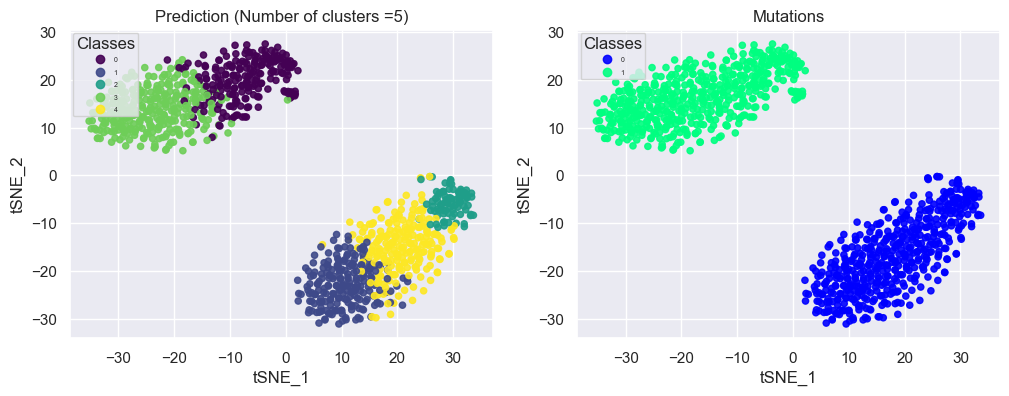


number of control cells  =  503
number of Mutation cells  =  504
Mutatation labels are [0, 3]
control labels are [1, 2, 4]


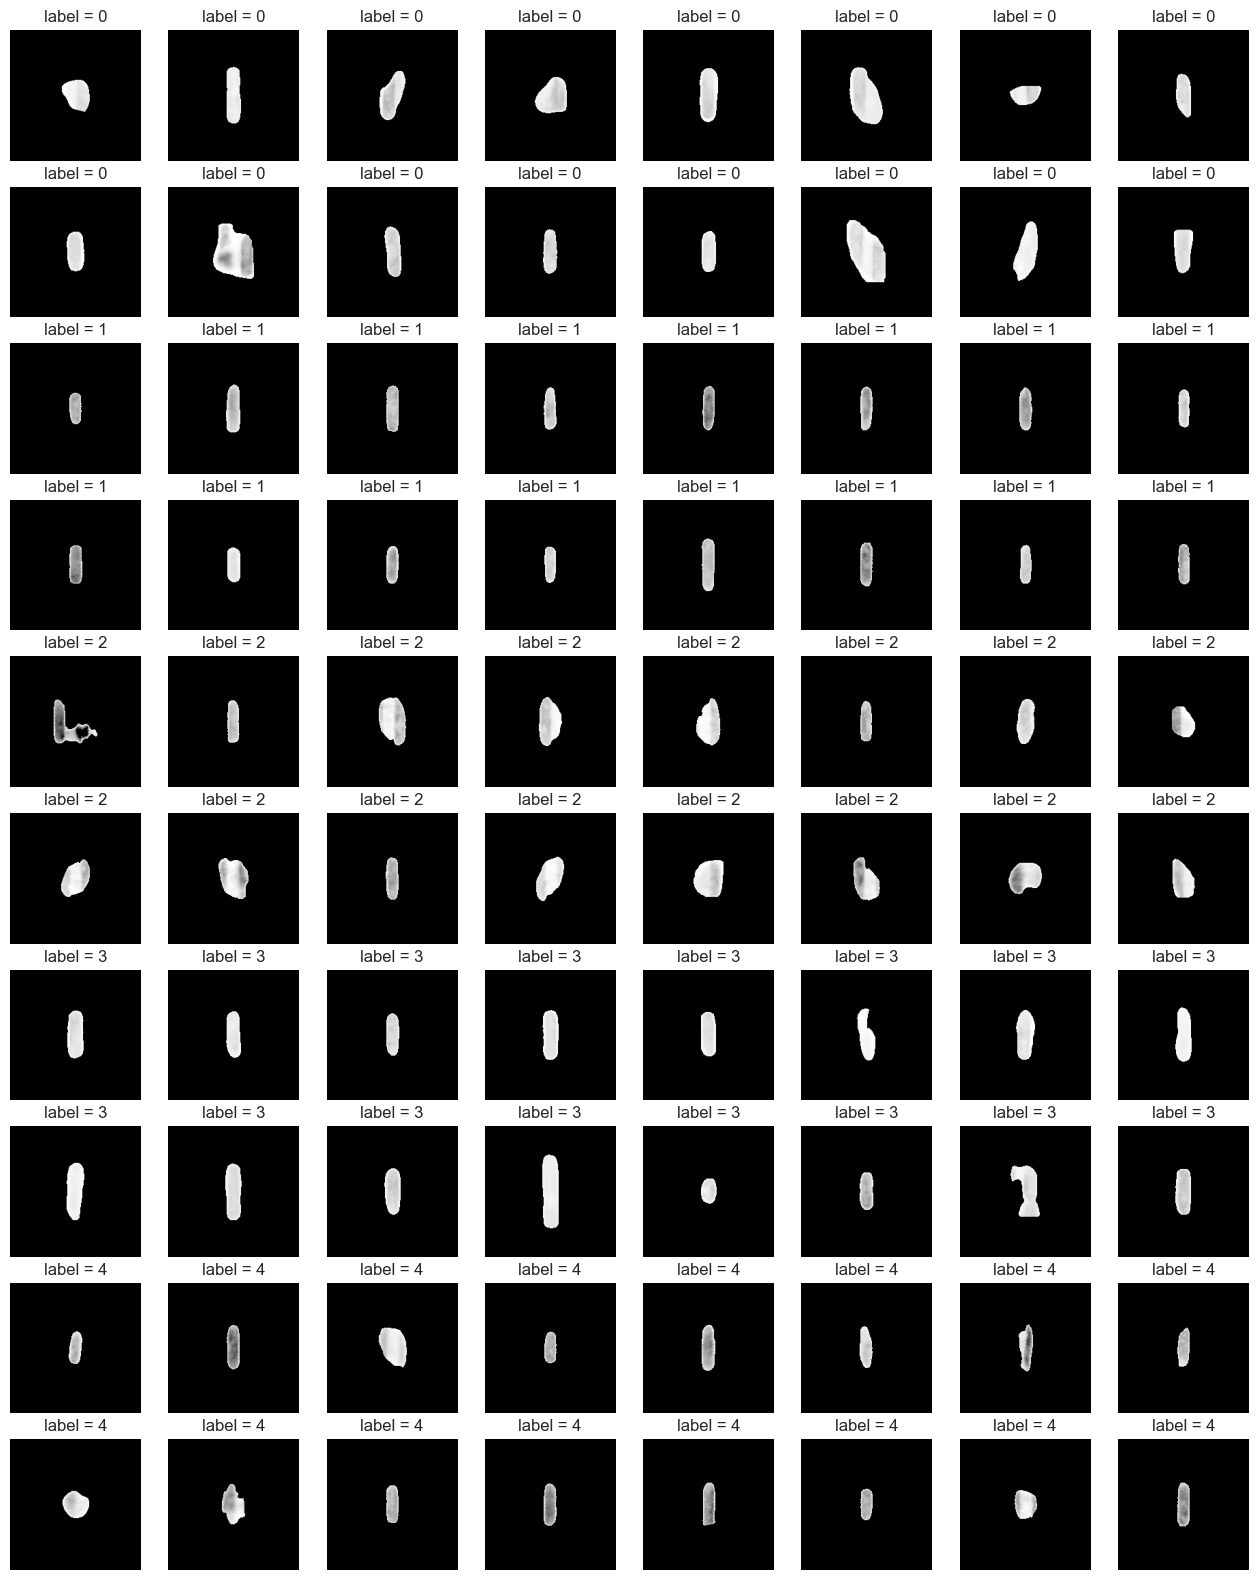

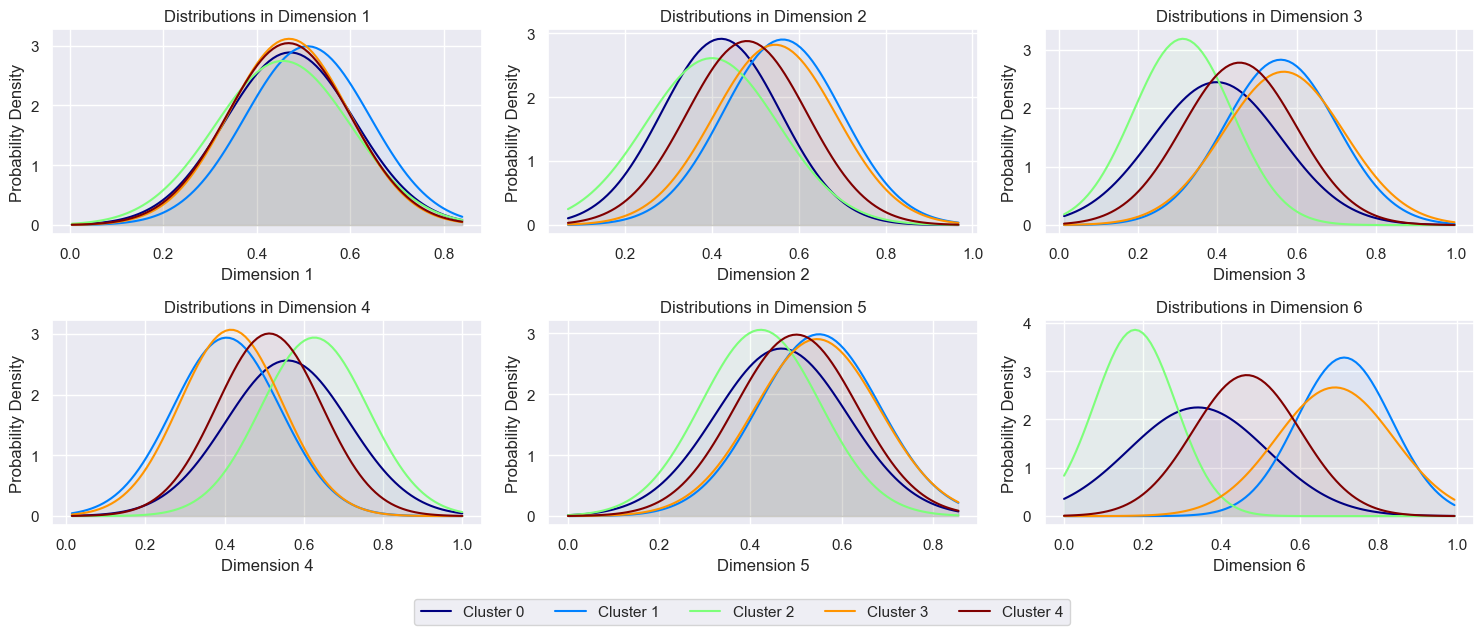

Silhouette: 0.4242, DB: 0.7850, CH: 3869.3416


In [18]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 5
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
proj_2d = tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=5,data="cells",cmap=cmap)
pourcentage_cells(clustering_labels,y_test)

# Samples from each cluster
nb_samples = 16
unique_labels = list(set(clustering_labels))
n_clusters = len(unique_labels)
fig, axes = plt.subplots(n_clusters * 2, nb_samples // 2, figsize=( nb_samples ,n_clusters * 4))

for label_index, label in enumerate(unique_labels):
    cluster_samples = X_test[clustering_labels == label]
    for row in range(2):
        for col in range(nb_samples // 2):
            sample_index = row * (nb_samples // 2) + col
            if sample_index < len(cluster_samples):
                axes[label_index * 2 + row, col].imshow(cluster_samples[sample_index][0], cmap='gray')
                axes[label_index * 2 + row, col].set_title(f"label = {label}")
                axes[label_index * 2 + row, col].grid(False)
                axes[label_index * 2 + row, col].axis('off')

plt.show()

plot_components(z_test,n_clusters,clustering,max_plots=6)

s_8_5 = silhouette_score(proj_2d, clustering_labels)
db_8_5 = davies_bouldin_score(proj_2d, clustering_labels)
ch_8_5 = calinski_harabasz_score(proj_2d, clustering_labels)
print(f"Silhouette: {s_8_5:.4f}, DB: {db_8_5:.4f}, CH: {ch_8_5:.4f}")



**Clustering using GaussianMixture : 7 clusters**

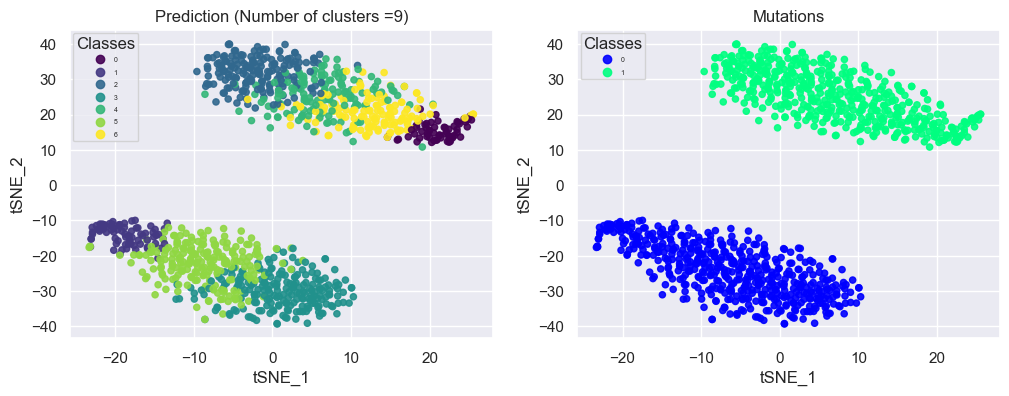


number of control cells  =  503
number of Mutation cells  =  504
Mutatation labels are [0, 2, 4, 6]
control labels are [1, 3, 5]


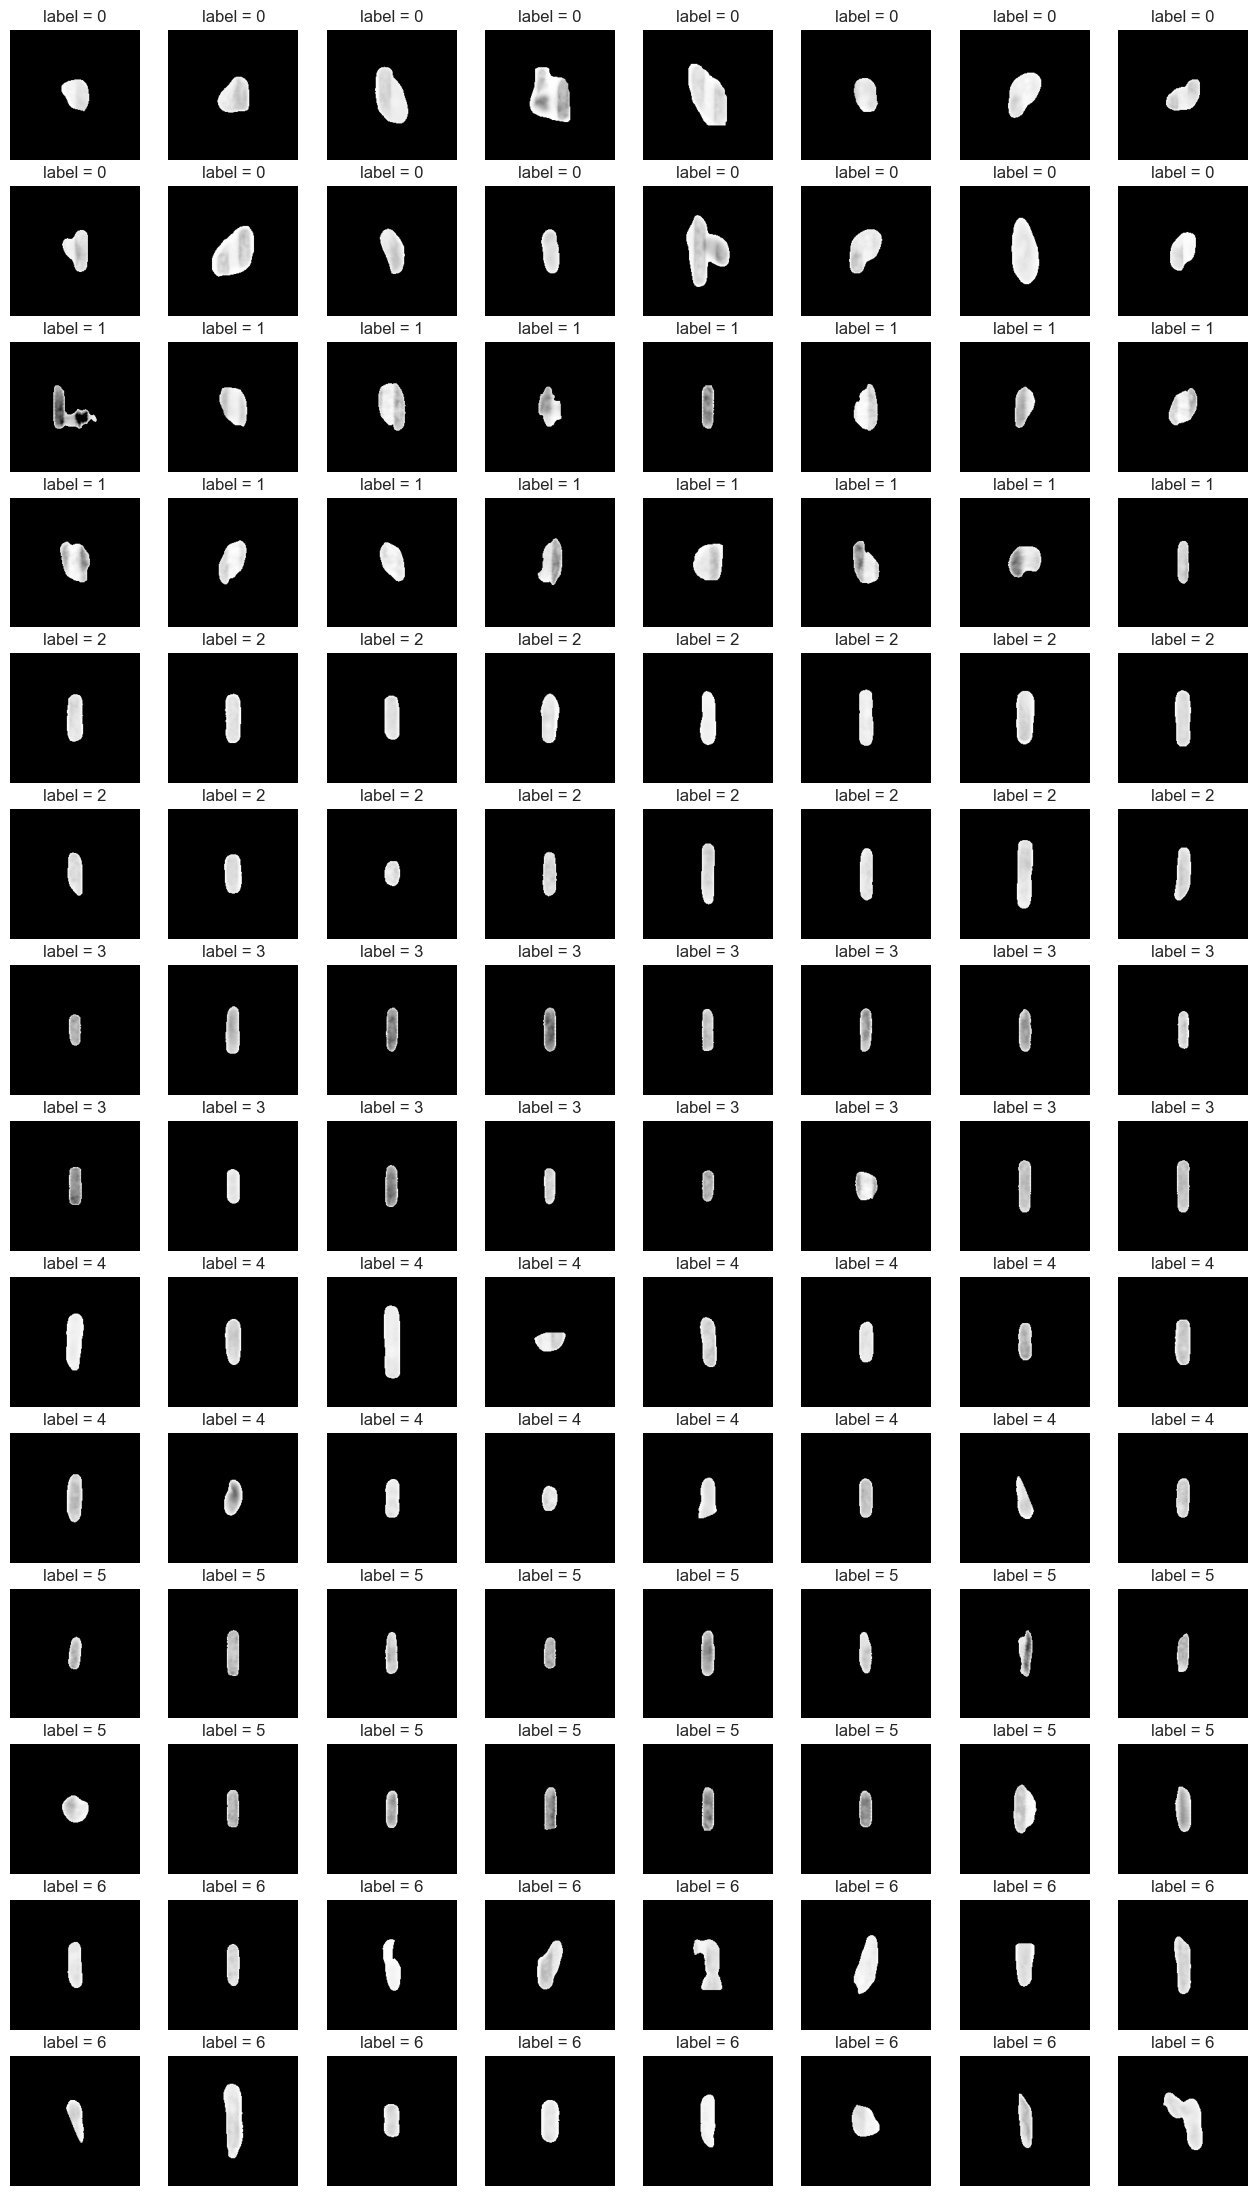

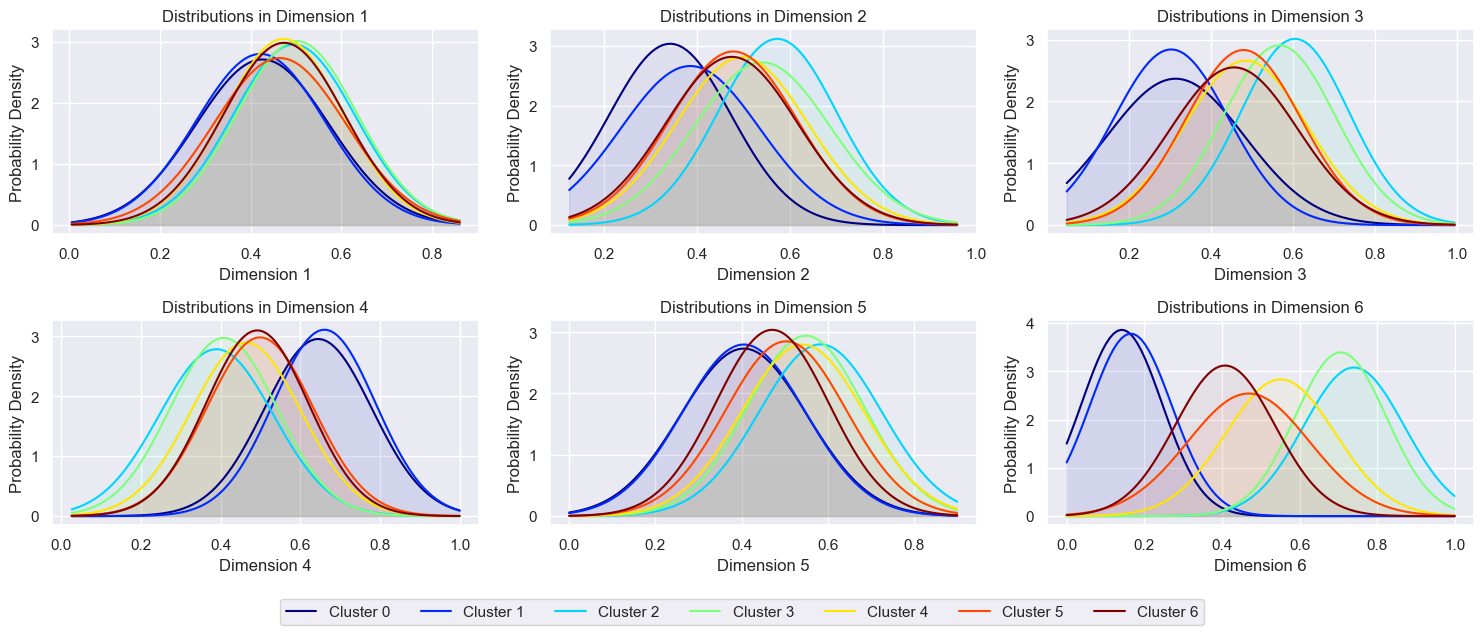

Silhouette: 0.2745, DB: 1.1047, CH: 3167.7190


In [23]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 7
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
proj_2d = tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=9,data="cells")
pourcentage_cells(clustering_labels,y_test)

# Samples from each cluster
nb_samples = 16
unique_labels = list(set(clustering_labels))
n_clusters = len(unique_labels)
fig, axes = plt.subplots(n_clusters * 2, nb_samples // 2, figsize=( nb_samples ,n_clusters * 4))

for label_index, label in enumerate(unique_labels):
    cluster_samples = X_test[clustering_labels == label]
    for row in range(2):
        for col in range(nb_samples // 2):
            sample_index = row * (nb_samples // 2) + col
            if sample_index < len(cluster_samples):
                axes[label_index * 2 + row, col].imshow(cluster_samples[sample_index][0], cmap='gray')
                axes[label_index * 2 + row, col].set_title(f"label = {label}")
                axes[label_index * 2 + row, col].grid(False)
                axes[label_index * 2 + row, col].axis('off')

plt.show()
plot_components(z_test,n_clusters,clustering,max_plots=6)

s_8_9 = silhouette_score(proj_2d, clustering_labels)
db_8_9 = davies_bouldin_score(proj_2d, clustering_labels)
ch_8_9 = calinski_harabasz_score(proj_2d, clustering_labels)
print(f"Silhouette: {s_8_9:.4f}, DB: {db_8_9:.4f}, CH: {ch_8_9:.4f}")



In [25]:
print(" ")

data = {'alpha_nbclusters': ['16_5','16_7', '8_5','8_7'],

        'Silhouette': [s_16_5, s_16_9, s_8_5, s_8_9],
        
        'DB': [db_16_5, db_16_9, db_8_5, db_8_9],

        'CH': [ch_16_5, ch_16_9, ch_8_5, ch_8_9]}

df = pd.DataFrame(data)

print(df.to_markdown(index=False))

 
|   alpha_nbclusters |   Silhouette |       DB |      CH |
|-------------------:|-------------:|---------:|--------:|
|               16_5 |     0.394324 | 0.820397 | 4109    |
|               16_7 |     0.301135 | 0.961042 | 3552.71 |
|                8_5 |     0.424161 | 0.785045 | 3869.34 |
|                8_7 |     0.274534 | 1.10468  | 3167.72 |
